Сделаны 3 улучшения:
* добавлен еще один полносвязный слой
* увеличен размер спектрограммы и добавлен случайный сдвиг
* выборка train и test сбалансированны

После всех улучшений val accuracy поднялась до 0,5375.

In [0]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

In [0]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])
        
        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))


In [0]:
train_folder = 'F:/Аудиоаналитика/audio_train/train/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

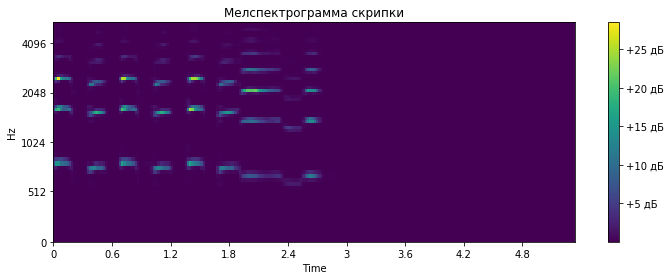

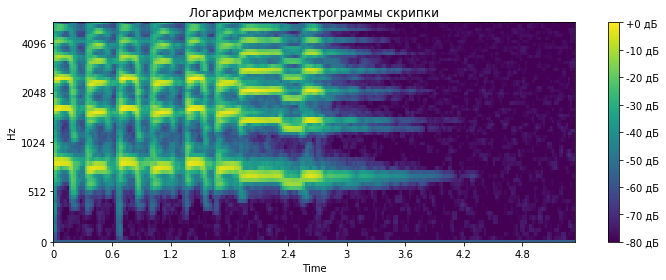

In [0]:
wav_data, sr = load(os.path.join(test_folder, '0a9f4e787d8d2af55683.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [0]:
path_to_csv = os.path.join('F:/Аудиоаналитика/', 'train.csv')

pickle_train_path = os.path.join('F:/Аудиоаналитика/', 'train.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

Total files: 8000


8000it [53:34,  2.57it/s]


In [0]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        # Улучшение 1
        # добавлен еще один слой
        self.fc1 = nn.Linear(80960, 2048)
        self.fc2 = nn.Linear(2048, 41)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # Улучшение 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [0]:
random_input = torch.randn(1, 1, 64, 128, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[ 0.4687,  0.1917,  0.0857,  0.0078, -0.2752,  0.4159,  0.0352, -0.2607,
         -0.1403,  0.4060,  0.0091, -0.1274, -0.8651, -0.2369,  0.1713, -0.8487,
         -0.1034,  0.6742, -0.0973,  0.4342,  0.1276,  0.7638,  0.3131, -0.0484,
          0.1648, -0.4156, -0.3294,  0.4305, -0.0089, -0.1961,  0.1951,  0.0810,
         -0.3673,  0.4498, -0.4293,  0.4670,  0.4759, -0.1770, -0.2382,  0.3278,
         -0.1004]], grad_fn=<AddmmBackward>)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 128, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)
loss = criterion(output, target)
print(loss.item())
loss.backward()
optimizer.step() 

3.5862064361572266


In [0]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [0]:
import random

# Улучшение 2

def prepare_shape(feature):
    tmp = feature
    N = 128 # увеличен размер
    while tmp.shape[1] < N:        
        tmp = np.hstack((tmp, tmp))
    rand_shift = random.randint(0, tmp.shape[1]-N) # случайный сдвиг
    tmp = tmp[np.newaxis, :, rand_shift:(rand_shift+N)]
    return tmp

In [0]:
from sklearn.model_selection import train_test_split

# Улучшение 3

validation_set_size = 800

features = []
labels = []

for i, row in enumerate(pickle_train_data):     
    features.append(np.asarray(row['feature']))
    labels.append(row['label_id'])
    
x_tr, x_val, y_tr, y_val = train_test_split(features, labels, test_size=validation_set_size/len(labels), random_state=42)

In [0]:
from torch.utils.data import Dataset

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.y is not None:
            return prepare_shape(self.x[idx]), self.y[idx] # перенесена функция
        return prepare_shape(self.x[idx])

In [0]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

Knock


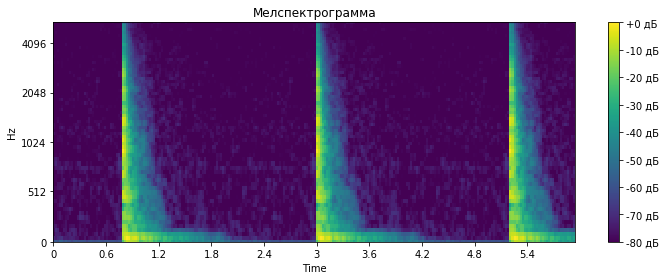

In [0]:
sample_x, sample_y = val_dset[52]
print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [0]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=16, shuffle=False, num_workers=0)

In [0]:
from sklearn.metrics import accuracy_score
import time

In [0]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

start_time = time.time()

for e in range(n_epoch):
    print('epoch #', e)
    
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        #output = network(x)
        output = network(x.float())
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched

            #output = network(x)
            output = network(x.float())
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)
    print('Сек: ', time.time() - start_time)

epoch # 0
mean train loss: 3.2069051203384897
train accuracy: 0.13925865246774524
mean val loss: 3.2692121696472167
val accuracy: 0.115
Сек:  399.91523599624634
epoch # 1
mean train loss: 2.786621487997716
train accuracy: 0.23161990579561745
mean val loss: 2.8575461673736573
val accuracy: 0.19375
Сек:  787.372709274292
epoch # 2
mean train loss: 2.5627193840500575
train accuracy: 0.283227524063076
mean val loss: 2.7447575759887695
val accuracy: 0.22125
Сек:  1173.3913433551788
epoch # 3
mean train loss: 2.42779868802214
train accuracy: 0.31906614785992216
mean val loss: 2.7761078548431395
val accuracy: 0.22125
Сек:  1555.7478132247925
epoch # 4
mean train loss: 2.319472589134391
train accuracy: 0.35429039524882244
mean val loss: 2.528258068561554
val accuracy: 0.30125
Сек:  1941.0342540740967
epoch # 5
mean train loss: 2.2387626062031667
train accuracy: 0.3764079459348761
mean val loss: 2.5027117943763733
val accuracy: 0.30125
Сек:  2325.108325481415
epoch # 6
mean train loss: 2.163020

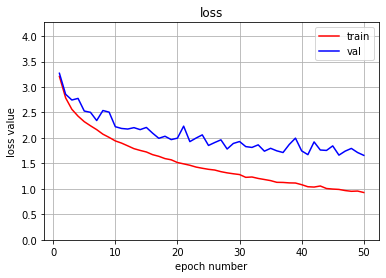

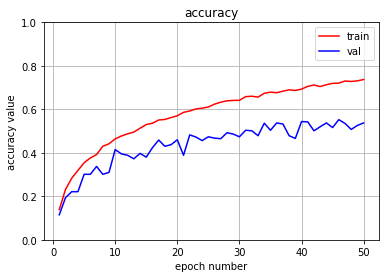

In [0]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()